In [2]:
# Install required packages
!pip install torch torchvision pytorch-lightning opencv-python scikit-image matplotlib lpips torchmetrics

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt

print(" All libraries installed and imported.")


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
error: invalid-installed-package

× Cannot process installed package pytorch-lightning 1.7.7 in '/users/PFS0270/nikhilchatta/.local/lib/python3.9/site-packages' because it has an invalid requirement:
│ .* suffix can only be used with `==` or `!=` operators
│     torch (>=1.9.*)
│            ~~~~~~^
╰─> Starting with pip 24.1, packages with invalid requirements can not be processed.

hint: To proceed this package must be uninstalled.
 All libraries installed and imported.


In [3]:
# Simple VAE for CIFAR-10
class VAE(pl.LightningModule):
    def __init__(self, latent_dim=256):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),  # (B, 32, 16, 16)
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), # (B, 64, 8, 8)
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), # (B, 128, 4, 4)
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(128*4*4, latent_dim)
        self.fc_var = nn.Linear(128*4*4, latent_dim)
        
        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 128*4*4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # (B, 64, 8, 8)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),   # (B, 32, 16, 16)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),    # (B, 3, 32, 32)
            nn.Tanh()
        )
    
    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        x = self.decoder_input(z)
        x = x.view(-1, 128, 4, 4)
        x = self.decoder(x)
        return x
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var
    
    def loss_function(self, recons, input, mu, log_var):
        recons_loss = F.mse_loss(recons, input, reduction='mean')
        kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) / input.size(0)
        return recons_loss + 0.0005 * kld_loss
    
    def training_step(self, batch, batch_idx):
        x, _ = batch
        recons, mu, log_var = self.forward(x)
        loss = self.loss_function(recons, x, mu, log_var)
        self.log('train_loss', loss)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


In [4]:
# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),          # Converts to [0, 1]
    transforms.Normalize((0.5,), (0.5,)) # Normalize to [-1, 1]
])

# CIFAR-10 Dataset
train_dataset = CIFAR10(root="./", train=True, download=True, transform=transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)

print(" CIFAR-10 dataset loaded and ready.")


100%|██████████| 170M/170M [00:02<00:00, 63.9MB/s] 


Extracting ./cifar-10-python.tar.gz to ./


/usr/lib64/python3.9/tarfile.py:2268: RuntimeWarning: The default behavior of tarfile extraction has been changed to disallow common exploits (including CVE-2007-4559). By default, absolute/parent paths are disallowed and some mode bits are cleared. See https://access.redhat.com/articles/7004769 for more details.
  warnings.warn(


 CIFAR-10 dataset loaded and ready.


In [32]:
# Initialize model
vae_model = VAE(latent_dim=256)

# Trainer
trainer = pl.Trainer(max_epochs=100, accelerator="gpu", devices="1", precision=32)

# Train
trainer.fit(vae_model, train_loader)

# Save trained VAE weights
torch.save(vae_model.state_dict(), "vae_cifar10.pth")

print(" VAE training completed and model saved.")


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/users/PFS0270/nikhilchatta/.local/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /users/PFS0270/nikhilchatta/lightning_logs/version_660196/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type       | Params
---------------------------------------------
0 | encoder       | Sequential | 165 K 
1 | fc_mu         | Linear     | 524 K 
2 | fc_var        | Linear     | 524 K 
3 | decoder_input | Linear     | 526 K 
4 | decoder       | Sequential | 165 K 
---------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.626     Total estimated model params size (MB)
/users/PFS0270/nikh

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


 VAE training completed and model saved.


In [33]:
# Correct UNet for latent diffusion
class UNet(pl.LightningModule):
    def __init__(self, latent_dim=256, time_emb_dim=256):
        super(UNet, self).__init__()
        
        # Timestep embedding
        self.time_mlp = nn.Sequential(
            nn.Linear(1, time_emb_dim),
            nn.ReLU(),
            nn.Linear(time_emb_dim, time_emb_dim)
        )
        
        # Encoder
        self.conv1 = nn.Conv1d(latent_dim, 512, 1)
        self.conv2 = nn.Conv1d(512, 512, 1)
        
        # Decoder
        self.deconv1 = nn.Conv1d(512, 512, 1)
        self.deconv2 = nn.Conv1d(512, latent_dim, 1)
        
    def forward(self, x, t):
        # x: (batch, latent_dim)
        # t: (batch,)
        
        t = t.unsqueeze(-1).float()  # (batch, 1)
        t_emb = self.time_mlp(t)     # (batch, time_emb_dim)
        t_emb = t_emb.unsqueeze(-1)  # (batch, time_emb_dim, 1)
        
        x = x.unsqueeze(-1)          # (batch, latent_dim, 1)
        
        # Add timestep embedding
        x = x + t_emb
        
        # UNet Forward
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.deconv1(x))
        x = self.deconv2(x)
        
        return x.squeeze(-1)  # (batch, latent_dim)

# Initialize UNet
unet_model = UNet(latent_dim=256)

# Trainer: Use only 1 GPU without setting any strategy
trainer = pl.Trainer(max_epochs=100, accelerator="gpu", devices=1, precision=32)

# Dummy input to check
x = torch.randn(4, 256)
t = torch.randint(0, 1000, (4,))
out = unet_model(x, t)
print(out.shape)  # Should be (4, 256)

print(" UNet built correctly for Latent Diffusion!")


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


torch.Size([4, 256])
 UNet built correctly for Latent Diffusion!


In [34]:
# Fixed Diffusion Class
class Diffusion:
    def __init__(self, timesteps=1000, beta_start=1e-4, beta_end=0.02):
        self.timesteps = timesteps
        self.beta = torch.linspace(beta_start, beta_end, timesteps)  # CPU tensor
        self.alpha = 1.0 - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)
    
    def q_sample(self, x_start, t, noise=None):
        """
        Forward diffusion: q(x_t | x_0)
        """
        if noise is None:
            noise = torch.randn_like(x_start)
        
        #  move alpha_hat to same device as x_start
        device = x_start.device
        alpha_hat = self.alpha_hat.to(device)

        sqrt_alpha_hat = torch.sqrt(alpha_hat[t]).unsqueeze(1)
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - alpha_hat[t]).unsqueeze(1)
        
        return sqrt_alpha_hat * x_start + sqrt_one_minus_alpha_hat * noise

    def predict_start_from_noise(self, x_t, t, noise):
        """
        Estimate x_0 from x_t and predicted noise
        """
        device = x_t.device
        alpha_hat = self.alpha_hat.to(device)

        sqrt_alpha_hat = torch.sqrt(alpha_hat[t]).unsqueeze(1)
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - alpha_hat[t]).unsqueeze(1)
        
        return (x_t - sqrt_one_minus_alpha_hat * noise) / sqrt_alpha_hat

    def p_sample(self, model, x_t, t):
        """
        Reverse sampling step: p(x_{t-1} | x_t)
        """
        noise_pred = model(x_t, t)
        x_start = self.predict_start_from_noise(x_t, t, noise_pred)
    
        device = x_t.device
        beta = self.beta.to(device)
        alpha = self.alpha.to(device)
        alpha_hat = self.alpha_hat.to(device)
    
        noise = torch.randn_like(x_t)
        nonzero_mask = (t != 0).float().unsqueeze(1)  # (batch_size, 1)
    
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - alpha_hat[t]).unsqueeze(1)
        out = torch.sqrt(alpha[t]).unsqueeze(1) * x_start + sqrt_one_minus_alpha_hat * noise

        return out * nonzero_mask + x_start * (1 - nonzero_mask)




In [35]:
# LDM Trainer (UNet + Diffusion)

class LDM(pl.LightningModule):
    def __init__(self, vae, unet, diffusion, latent_dim=256, timesteps=1000):
        super().__init__()
        self.vae = vae
        self.unet = unet
        self.diffusion = diffusion
        self.latent_dim = latent_dim
        self.timesteps = timesteps
        
        # Freeze VAE (only use encoder)
        for param in self.vae.parameters():
            param.requires_grad = False
    
    def training_step(self, batch, batch_idx):
        imgs, _ = batch
        
        # 1. Encode images to latent space
        mu, log_var = self.vae.encode(imgs)
        z = self.vae.reparameterize(mu, log_var)  # latent vector (batch, latent_dim)
        
        # 2. Sample random timesteps
        batch_size = z.shape[0]
        t = torch.randint(0, self.timesteps, (batch_size,), device=self.device).long()
        
        # 3. Add noise
        noise = torch.randn_like(z)
        z_noisy = self.diffusion.q_sample(z, t, noise=noise)
        
        # 4. Predict noise with UNet
        noise_pred = self.unet(z_noisy, t)
        
        # 5. Loss: MSE between true noise and predicted noise
        loss = F.mse_loss(noise_pred, noise)
        self.log('train_loss', loss)
        
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.unet.parameters(), lr=1e-4)


In [36]:
# Load trained VAE
vae_model = VAE(latent_dim=256)
vae_model.load_state_dict(torch.load("vae_cifar10.pth", map_location="cpu"))
vae_model.eval()  # important

# Initialize UNet
unet_model = UNet(latent_dim=256)

# Initialize Diffusion
diffusion = Diffusion(timesteps=1000)

# Initialize LDM
ldm_model = LDM(vae=vae_model, unet=unet_model, diffusion=diffusion, latent_dim=256, timesteps=1000)

# Trainer (use single GPU, no distributed)
trainer = pl.Trainer(max_epochs=100, accelerator="gpu", devices=1, precision=32)

# Train LDM
trainer.fit(ldm_model, train_loader)

# Save UNet after training
torch.save(ldm_model.unet.state_dict(), "unet_ldm_cifar10.pth")

print(" LDM training finished and UNet model saved!")


/tmp/slurmtmp.660196/ipykernel_3271377/30379419.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae_model.load_state_dict(torch.load("vae_cifar10.pth", map_location="cpu

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


 LDM training finished and UNet model saved!


/tmp/slurmtmp.660196/ipykernel_3271377/2463865566.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet_model.load_state_dict(torch.load("unet_ldm_cifar10.pth", map_loca

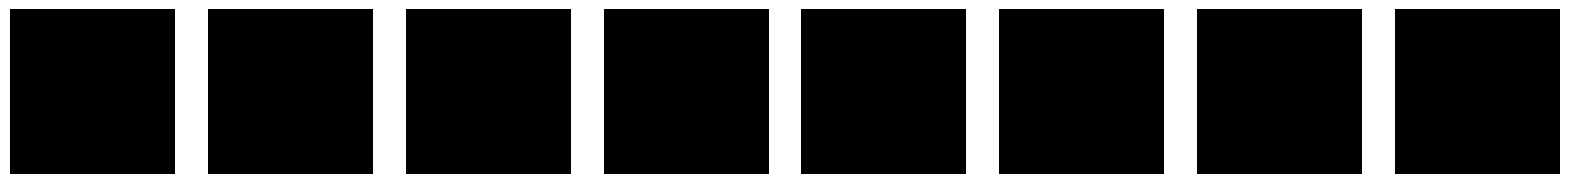

In [37]:
# Sampling function
def sample_ldm(unet, vae, diffusion, num_samples=8, latent_dim=256, timesteps=1000):
    unet.eval()
    vae.eval()
    
    device = next(unet.parameters()).device
    
    # Start from pure Gaussian noise
    x = torch.randn(num_samples, latent_dim).to(device)
    
    # Reverse diffusion (iteratively remove noise)
    for t in reversed(range(timesteps)):
        t_batch = torch.full((num_samples,), t, device=device, dtype=torch.long)
        x = diffusion.p_sample(unet, x, t_batch)
    
    # Decode latent vectors into images
    with torch.no_grad():
        decoded_imgs = vae.decode(x).cpu()
    
    return decoded_imgs

# Load the trained UNet
unet_model = UNet(latent_dim=256)
unet_model.load_state_dict(torch.load("unet_ldm_cifar10.pth", map_location="cuda"))
unet_model = unet_model.cuda()

# Sampling
generated_images = sample_ldm(unet=unet_model, vae=vae_model.cuda(), diffusion=Diffusion(timesteps=1000), num_samples=8)

# Plot
fig, axes = plt.subplots(1, 8, figsize=(20, 5))
for i, ax in enumerate(axes):
    img = (generated_images[i].permute(1, 2, 0) + 1) / 2  # de-normalize from [-1,1] to [0,1]
    img = img.clamp(0, 1)
    ax.imshow(img)
    ax.axis('off')
plt.show()


In [38]:
# Generate 1000 samples
def generate_samples(unet, vae, diffusion, num_samples=1000, latent_dim=256, timesteps=1000):
    unet.eval()
    vae.eval()
    
    device = next(unet.parameters()).device
    samples = []
    
    batch_size = 100  # Generate 100 at a time (10 batches)
    for _ in range(num_samples // batch_size):
        x = torch.randn(batch_size, latent_dim).to(device)
        for t in reversed(range(timesteps)):
            t_batch = torch.full((batch_size,), t, device=device, dtype=torch.long)
            x = diffusion.p_sample(unet, x, t_batch)
        decoded_imgs = vae.decode(x).cpu()
        samples.append(decoded_imgs)
    
    samples = torch.cat(samples, dim=0)  # (1000, 3, 32, 32)
    return samples

# Generate 1000 fake images
generated_images = generate_samples(
    unet=unet_model,
    vae=vae_model.cuda(),
    diffusion=Diffusion(timesteps=1000),
    num_samples=1000
)

print(f" Generated {generated_images.shape[0]} images.")


 Generated 1000 images.


In [42]:
# Imports (if needed)
from torchvision.datasets import CIFAR10
from torchvision import transforms
import torch
import torch.nn.functional as F
from skimage.metrics import peak_signal_noise_ratio as psnr_metric

# De-normalization helper
def denormalize(imgs):
    return (imgs + 1) / 2

# Create Diffusion object correctly with 1000 timesteps
diffusion_obj = Diffusion(timesteps=1000)

# CIFAR-10 real images (download/test set)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
cifar_test = CIFAR10(root="./", train=False, download=True, transform=transform)
real_images = torch.stack([cifar_test[i][0] for i in range(1000)])  # (1000, 3, 32, 32)

# Function to generate 1000 samples and compute PSNR
def compute_psnr_round(unet, vae, diffusion, real_images, num_samples=1000, latent_dim=256, timesteps=1000):
    device = next(unet.parameters()).device
    samples = []
    
    batch_size = 100
    for _ in range(num_samples // batch_size):
        x = torch.randn(batch_size, latent_dim).to(device)
        for t in reversed(range(timesteps)):
            t_batch = torch.full((batch_size,), t, device=device, dtype=torch.long)
            x = diffusion.p_sample(unet, x, t_batch)
        decoded_imgs = vae.decode(x).cpu()
        samples.append(decoded_imgs)
    
    generated_images = torch.cat(samples, dim=0)
    generated_images_denorm = denormalize(generated_images)
    real_images_denorm = denormalize(real_images)
    
    psnr_scores = []
    for i in range(num_samples):
        fake = generated_images_denorm[i].permute(1, 2, 0).detach().numpy()
        real = real_images_denorm[i].permute(1, 2, 0).detach().numpy()
        score = psnr_metric(real, fake, data_range=1.0)
        psnr_scores.append(score)
    
    return sum(psnr_scores) / len(psnr_scores)

# Run PSNR for 20 rounds
# Run PSNR for 20 rounds with 50 timesteps
psnr_all_rounds = []

for round_num in range(20):
    print(f" Running Round {round_num+1}/20...")
    psnr_score = compute_psnr_round(
        unet=unet_model,
        vae=vae_model.cuda(),
        diffusion=diffusion_obj,
        real_images=real_images,
        timesteps=50  # 50 steps only
    )
    psnr_all_rounds.append(psnr_score)
    print(f"Round {round_num+1} PSNR: {psnr_score:.4f} dB")

# Final Report
psnr_mean = sum(psnr_all_rounds) / len(psnr_all_rounds)
psnr_std = (sum((x - psnr_mean)**2 for x in psnr_all_rounds))**0.5

print(f"\n Final Average PSNR over 20 rounds: {psnr_mean:.4f} dB ± {psnr_std:.4f}")



Files already downloaded and verified
 Running Round 1/20...
Round 1 PSNR: 8.3465 dB
 Running Round 2/20...
Round 2 PSNR: 8.3080 dB
 Running Round 3/20...
Round 3 PSNR: 8.3031 dB
 Running Round 4/20...
Round 4 PSNR: 8.3171 dB
 Running Round 5/20...
Round 5 PSNR: 8.3566 dB
 Running Round 6/20...
Round 6 PSNR: 8.3046 dB
 Running Round 7/20...
Round 7 PSNR: 8.2641 dB
 Running Round 8/20...
Round 8 PSNR: 8.3315 dB
 Running Round 9/20...
Round 9 PSNR: 8.3743 dB
 Running Round 10/20...
Round 10 PSNR: 8.2931 dB
 Running Round 11/20...
Round 11 PSNR: 8.2423 dB
 Running Round 12/20...
Round 12 PSNR: 8.2368 dB
 Running Round 13/20...
Round 13 PSNR: 8.3908 dB
 Running Round 14/20...
Round 14 PSNR: 8.3702 dB
 Running Round 15/20...
Round 15 PSNR: 8.3725 dB
 Running Round 16/20...
Round 16 PSNR: 8.3377 dB
 Running Round 17/20...
Round 17 PSNR: 8.3331 dB
 Running Round 18/20...
Round 18 PSNR: 8.3323 dB
 Running Round 19/20...
Round 19 PSNR: 8.3521 dB
 Running Round 20/20...
Round 20 PSNR: 8.3227 dB


In [43]:
# Imports if needed
from skimage.metrics import structural_similarity as ssim_metric

# De-normalization helper (if not already defined)
def denormalize(imgs):
    return (imgs + 1) / 2

# Function to generate 1000 samples and compute SSIM
def compute_ssim_round(unet, vae, diffusion, real_images, num_samples=1000, latent_dim=256, timesteps=50):
    device = next(unet.parameters()).device
    samples = []
    
    batch_size = 100
    for _ in range(num_samples // batch_size):
        x = torch.randn(batch_size, latent_dim).to(device)
        for t in reversed(range(timesteps)):
            t_batch = torch.full((batch_size,), t, device=device, dtype=torch.long)
            x = diffusion.p_sample(unet, x, t_batch)
        decoded_imgs = vae.decode(x).cpu()
        samples.append(decoded_imgs)
    
    generated_images = torch.cat(samples, dim=0)
    generated_images_denorm = denormalize(generated_images)
    real_images_denorm = denormalize(real_images)
    
    ssim_scores = []
    for i in range(num_samples):
        fake = generated_images_denorm[i].permute(1, 2, 0).detach().numpy()
        real = real_images_denorm[i].permute(1, 2, 0).detach().numpy()
        score = ssim_metric(real, fake, data_range=1.0, channel_axis=2)
        ssim_scores.append(score)
    
    return sum(ssim_scores) / len(ssim_scores)

# Now run SSIM for 20 rounds
ssim_all_rounds = []

for round_num in range(20):
    print(f" Running SSIM Round {round_num+1}/20...")
    ssim_score = compute_ssim_round(
        unet=unet_model,
        vae=vae_model.cuda(),
        diffusion=diffusion_obj,  # using 50 step diffusion
        real_images=real_images,
        timesteps=50
    )
    ssim_all_rounds.append(ssim_score)
    print(f"Round {round_num+1} SSIM: {ssim_score:.4f}")

# Final Report
ssim_mean = sum(ssim_all_rounds) / len(ssim_all_rounds)
ssim_std = (sum([(x - ssim_mean)**2 for x in ssim_all_rounds]) / len(ssim_all_rounds))**0.5

print(f"\n Final Average SSIM over 20 rounds: {ssim_mean:.4f} ± {ssim_std:.4f}")


 Running SSIM Round 1/20...
Round 1 SSIM: 0.0275
 Running SSIM Round 2/20...
Round 2 SSIM: 0.0336
 Running SSIM Round 3/20...
Round 3 SSIM: 0.0312
 Running SSIM Round 4/20...
Round 4 SSIM: 0.0310
 Running SSIM Round 5/20...
Round 5 SSIM: 0.0304
 Running SSIM Round 6/20...
Round 6 SSIM: 0.0269
 Running SSIM Round 7/20...
Round 7 SSIM: 0.0269
 Running SSIM Round 8/20...
Round 8 SSIM: 0.0302
 Running SSIM Round 9/20...
Round 9 SSIM: 0.0274
 Running SSIM Round 10/20...
Round 10 SSIM: 0.0331
 Running SSIM Round 11/20...
Round 11 SSIM: 0.0319
 Running SSIM Round 12/20...
Round 12 SSIM: 0.0302
 Running SSIM Round 13/20...
Round 13 SSIM: 0.0337
 Running SSIM Round 14/20...
Round 14 SSIM: 0.0297
 Running SSIM Round 15/20...
Round 15 SSIM: 0.0296
 Running SSIM Round 16/20...
Round 16 SSIM: 0.0304
 Running SSIM Round 17/20...
Round 17 SSIM: 0.0339
 Running SSIM Round 18/20...
Round 18 SSIM: 0.0362
 Running SSIM Round 19/20...
Round 19 SSIM: 0.0297
 Running SSIM Round 20/20...
Round 20 SSIM: 0.030

In [44]:
# Imports
import torchvision.models as models
import torch.nn.functional as F

# Load Pretrained VGG16 model (for feature extraction)
vgg16 = models.vgg16(pretrained=True).features.eval().cuda()

# We will use features up to layer 16 (before classifier starts)
vgg_layers = torch.nn.Sequential(*list(vgg16.children())[:16])

# Freeze VGG parameters
for param in vgg_layers.parameters():
    param.requires_grad = False

# Normalize images as required by VGG
vgg_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])

# Denormalization helper (already defined earlier if needed)
def denormalize(imgs):
    return (imgs + 1) / 2

# Function to compute perceptual similarity between batches
def compute_perceptual_round(unet, vae, diffusion, real_images, num_samples=1000, latent_dim=256, timesteps=50):
    device = next(unet.parameters()).device
    samples = []
    
    batch_size = 100
    for _ in range(num_samples // batch_size):
        x = torch.randn(batch_size, latent_dim).to(device)
        for t in reversed(range(timesteps)):
            t_batch = torch.full((batch_size,), t, device=device, dtype=torch.long)
            x = diffusion.p_sample(unet, x, t_batch)
        decoded_imgs = vae.decode(x).cpu()
        samples.append(decoded_imgs)
    
    generated_images = torch.cat(samples, dim=0)
    generated_images_denorm = denormalize(generated_images)
    real_images_denorm = denormalize(real_images)
    
    perceptual_scores = []
    for i in range(num_samples):
        fake = generated_images_denorm[i].unsqueeze(0).cuda()  # (1,3,32,32)
        real = real_images_denorm[i].unsqueeze(0).cuda()
        
        # Resize to 224x224 for VGG
        fake_resized = F.interpolate(fake, size=(224, 224), mode='bilinear', align_corners=False)
        real_resized = F.interpolate(real, size=(224, 224), mode='bilinear', align_corners=False)
        
        # Normalize for VGG
        fake_norm = vgg_normalize(fake_resized.squeeze(0)).unsqueeze(0)
        real_norm = vgg_normalize(real_resized.squeeze(0)).unsqueeze(0)
        
        # Extract features
        fake_feat = vgg_layers(fake_norm)
        real_feat = vgg_layers(real_norm)
        
        # Cosine Similarity
        similarity = F.cosine_similarity(fake_feat.flatten(1), real_feat.flatten(1)).mean().item()
        
        perceptual_scores.append(similarity)
    
    return sum(perceptual_scores) / len(perceptual_scores)

# Run Perceptual Similarity for 20 rounds
perceptual_all_rounds = []

for round_num in range(20):
    print(f" Running Perceptual Round {round_num+1}/20...")
    perceptual_score = compute_perceptual_round(
        unet=unet_model,
        vae=vae_model.cuda(),
        diffusion=diffusion_obj,  # using 50 steps diffusion
        real_images=real_images,
        timesteps=50
    )
    perceptual_all_rounds.append(perceptual_score)
    print(f"Round {round_num+1} Perceptual Similarity: {perceptual_score:.4f}")

# Final Report
perceptual_mean = sum(perceptual_all_rounds) / len(perceptual_all_rounds)
perceptual_std = (sum([(x - perceptual_mean)**2 for x in perceptual_all_rounds]) / len(perceptual_all_rounds))**0.5

print(f"\n Final Average Perceptual Similarity over 20 rounds: {perceptual_mean:.4f} ± {perceptual_std:.4f}")


/users/PFS0270/nikhilchatta/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/users/PFS0270/nikhilchatta/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


 Running Perceptual Round 1/20...
Round 1 Perceptual Similarity: 0.2092
 Running Perceptual Round 2/20...
Round 2 Perceptual Similarity: 0.2119
 Running Perceptual Round 3/20...
Round 3 Perceptual Similarity: 0.2109
 Running Perceptual Round 4/20...
Round 4 Perceptual Similarity: 0.2105
 Running Perceptual Round 5/20...
Round 5 Perceptual Similarity: 0.2104
 Running Perceptual Round 6/20...
Round 6 Perceptual Similarity: 0.2109
 Running Perceptual Round 7/20...
Round 7 Perceptual Similarity: 0.2096
 Running Perceptual Round 8/20...
Round 8 Perceptual Similarity: 0.2112
 Running Perceptual Round 9/20...
Round 9 Perceptual Similarity: 0.2106
 Running Perceptual Round 10/20...
Round 10 Perceptual Similarity: 0.2109
 Running Perceptual Round 11/20...
Round 11 Perceptual Similarity: 0.2110
 Running Perceptual Round 12/20...
Round 12 Perceptual Similarity: 0.2110
 Running Perceptual Round 13/20...
Round 13 Perceptual Similarity: 0.2103
 Running Perceptual Round 14/20...
Round 14 Perceptual S

In [45]:
# Imports if needed
from torchvision.models import inception_v3
import numpy as np
from scipy import linalg

# Load pretrained InceptionV3 model
inception_model = inception_v3(pretrained=True, transform_input=False).eval().cuda()

# We only use features, so remove final fc layer
inception_model.fc = torch.nn.Identity()

# De-normalization helper (already defined if needed)
def denormalize(imgs):
    return (imgs + 1) / 2

# Extract features from InceptionV3
def get_inception_features(imgs):
    device = next(inception_model.parameters()).device
    
    # Resize to 299x299
    imgs_resized = F.interpolate(imgs, size=(299, 299), mode='bilinear', align_corners=False)
    features = inception_model(imgs_resized)
    
    return features.detach().cpu().numpy()

# Function to calculate FID between two sets of activations
def calculate_fid(act1, act2):
    mu1 = np.mean(act1, axis=0)
    mu2 = np.mean(act2, axis=0)
    sigma1 = np.cov(act1, rowvar=False)
    sigma2 = np.cov(act2, rowvar=False)
    
    diff = mu1 - mu2
    
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# Function to generate 1000 samples and compute FID
def compute_fid_round(unet, vae, diffusion, real_images, num_samples=1000, latent_dim=256, timesteps=50):
    device = next(unet.parameters()).device
    samples = []
    
    batch_size = 100
    for _ in range(num_samples // batch_size):
        x = torch.randn(batch_size, latent_dim).to(device)
        for t in reversed(range(timesteps)):
            t_batch = torch.full((batch_size,), t, device=device, dtype=torch.long)
            x = diffusion.p_sample(unet, x, t_batch)
        decoded_imgs = vae.decode(x).cpu()
        samples.append(decoded_imgs)
    
    generated_images = torch.cat(samples, dim=0)
    generated_images_denorm = denormalize(generated_images)
    real_images_denorm = denormalize(real_images)
    
    # Normalize for Inception
    generated_images_incep = generated_images_denorm * 2 - 1  # back to [-1,1] for inception
    real_images_incep = real_images_denorm * 2 - 1
    
    # Extract features
    fake_acts = []
    real_acts = []
    batch_size = 100
    for i in range(0, num_samples, batch_size):
        fake_batch = generated_images_incep[i:i+batch_size].cuda()
        real_batch = real_images_incep[i:i+batch_size].cuda()
        
        fake_acts.append(get_inception_features(fake_batch))
        real_acts.append(get_inception_features(real_batch))
    
    fake_acts = np.concatenate(fake_acts, axis=0)
    real_acts = np.concatenate(real_acts, axis=0)
    
    fid_score = calculate_fid(fake_acts, real_acts)
    
    return fid_score

# Run FID for 20 rounds
fid_all_rounds = []

for round_num in range(20):
    print(f" Running FID Round {round_num+1}/20...")
    fid_score = compute_fid_round(
        unet=unet_model,
        vae=vae_model.cuda(),
        diffusion=diffusion_obj,  # using 50 step diffusion
        real_images=real_images,
        timesteps=50
    )
    fid_all_rounds.append(fid_score)
    print(f"Round {round_num+1} FID: {fid_score:.4f}")

# Final Report
fid_mean = sum(fid_all_rounds) / len(fid_all_rounds)
fid_std = (sum([(x - fid_mean)**2 for x in fid_all_rounds]) / len(fid_all_rounds))**0.5

print(f"\n Final Average FID over 20 rounds: {fid_mean:.4f} ± {fid_std:.4f}")


/users/PFS0270/nikhilchatta/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


 Running FID Round 1/20...
Round 1 FID: 146.7681
 Running FID Round 2/20...
Round 2 FID: 148.8888
 Running FID Round 3/20...
Round 3 FID: 148.5847
 Running FID Round 4/20...
Round 4 FID: 148.5047
 Running FID Round 5/20...
Round 5 FID: 147.8991
 Running FID Round 6/20...
Round 6 FID: 147.3239
 Running FID Round 7/20...
Round 7 FID: 146.5880
 Running FID Round 8/20...
Round 8 FID: 148.4425
 Running FID Round 9/20...
Round 9 FID: 148.1095
 Running FID Round 10/20...
Round 10 FID: 148.9086
 Running FID Round 11/20...
Round 11 FID: 147.7468
 Running FID Round 12/20...
Round 12 FID: 146.8986
 Running FID Round 13/20...
Round 13 FID: 150.1813
 Running FID Round 14/20...
Round 14 FID: 146.9177
 Running FID Round 15/20...
Round 15 FID: 147.4944
 Running FID Round 16/20...
Round 16 FID: 148.4953
 Running FID Round 17/20...
Round 17 FID: 147.6626
 Running FID Round 18/20...
Round 18 FID: 148.8303
 Running FID Round 19/20...
Round 19 FID: 148.0432
 Running FID Round 20/20...
Round 20 FID: 147.567

In [53]:
# Imports
import os
import torch
import torchvision.utils as vutils

# Create save folder
save_folder = "generated_samples"
os.makedirs(save_folder, exist_ok=True)

# CPU Sampling and Saving Function
def generate_and_save_samples_cpu(unet, vae, diffusion, save_folder, num_samples=1000, latent_dim=256, timesteps=50):
    device = torch.device("cpu")  # Force CPU

    # Move models to CPU
    unet = unet.to(device)
    vae = vae.to(device)

    batch_size = 10  # Small batch to avoid memory pressure even on CPU
    idx = 0

    for _ in range(num_samples // batch_size):
        x = torch.randn(batch_size, latent_dim).to(device)
        for t in reversed(range(timesteps)):
            t_batch = torch.full((batch_size,), t, device=device, dtype=torch.long)
            x = diffusion.p_sample(unet, x, t_batch)
        decoded_imgs = vae.decode(x).cpu()  # Output shape: (batch_size, 3, 32, 32)
        decoded_imgs = (decoded_imgs + 1) / 2  # Denormalize from [-1,1] to [0,1]

        # Save each image individually
        for img in decoded_imgs:
            save_path = os.path.join(save_folder, f"{idx:04d}.png")
            vutils.save_image(img, save_path)
            idx += 1

    print(f"\n Done: Saved {idx} images to '{save_folder}' folder.")

# Example usage:
generate_and_save_samples_cpu(
    unet=unet_model,
    vae=vae_model,
    diffusion=diffusion_obj,
    save_folder=save_folder,
    num_samples=1000,       
    latent_dim=256,
    timesteps=50
)



 Done: Saved 1000 images to 'generated_samples' folder.


In [55]:
pip install --upgrade torchmetrics


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 9.5 MB/s eta 0:00:00
    torch (>=1.9.*)
           ~~~~~~^
  Attempting uninstall: torchmetrics
    Found existing installation: torchmetrics 0.6.0
    Not uninstalling torchmetrics at /users/PFS0270/nikhilchatta/.local/lib/python3.9/site-packages, outside environment /apps/project/ondemand/app_jupyter/4.1.5
    Can't uninstall 'torchmetrics'. No files were found to uninstall.

[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [57]:
# Imports
import torch
import torchvision.transforms as T
import torchvision.models as models
import torch.nn.functional as F
from torchvision.datasets.folder import default_loader
import os
import random
import numpy as np

# Folder where saved images are
save_folder = "generated_samples"

# Define Transform: Resize to 299x299
transform = T.Compose([
    T.Resize((299, 299)),
    T.ToTensor(),
])

# Define custom dataset
class SimpleImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_filenames = sorted(os.listdir(image_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        img = default_loader(img_path)  # PIL image
        if self.transform:
            img = self.transform(img)
        return img

# Load dataset
dataset = SimpleImageDataset(save_folder, transform=transform)

# Load all images into memory
print(" Loading all saved images...")
all_images = []
for idx in range(len(dataset)):
    all_images.append(dataset[idx])

all_images = torch.stack(all_images, dim=0)
print(f" Loaded {all_images.shape[0]} images.")

# Load InceptionV3 model (CPU safe)
inception_model = models.inception_v3(pretrained=True, transform_input=False)
inception_model.fc = torch.nn.Identity()  # Remove classification head
inception_model.eval()
inception_model = inception_model.cpu()

# Function to calculate IS manually
def calculate_inception_score(preds, splits=10):
    preds = np.asarray(preds)
    scores = []
    split_size = preds.shape[0] // splits
    for i in range(splits):
        part = preds[i * split_size: (i + 1) * split_size]
        kl = part * (np.log(part) - np.log(np.expand_dims(np.mean(part, 0), 0)))
        kl = np.mean(np.sum(kl, axis=1))
        scores.append(np.exp(kl))
    return np.mean(scores), np.std(scores)

# 20 Rounds Inception Score
round_scores = []
num_rounds = 20
num_samples_per_round = 500

print("\n Calculating Inception Score for 20 rounds...")

for round_num in range(num_rounds):
    # Randomly pick 500 images for each round
    indices = random.sample(range(len(all_images)), num_samples_per_round)
    selected_images = all_images[indices]

    preds = []
    batch_size = 10  # Safe for CPU
    for i in range(0, selected_images.shape[0], batch_size):
        batch = selected_images[i:i+batch_size]
        batch_resized = F.interpolate(batch, size=(299, 299), mode='bilinear', align_corners=False)
        logits = inception_model(batch_resized)
        preds.append(F.softmax(logits, dim=1).detach().cpu().numpy())

    preds = np.concatenate(preds, axis=0)

    mean_is, std_is = calculate_inception_score(preds, splits=10)
    round_scores.append(mean_is)
    print(f" Round {round_num+1}: Inception Score = {mean_is:.4f}")

# Final Results
is_mean = sum(round_scores) / len(round_scores)
is_std = (sum([(x - is_mean)**2 for x in round_scores]) / len(round_scores))**0.5

print(f"\n Final Inception Score over {num_rounds} rounds: {is_mean:.4f} ± {is_std:.4f}")


 Loading all saved images...
 Loaded 1000 images.

 Calculating Inception Score for 20 rounds...
 Round 1: Inception Score = 1.1485
 Round 2: Inception Score = 1.1480
 Round 3: Inception Score = 1.1499
 Round 4: Inception Score = 1.1468
 Round 5: Inception Score = 1.1473
 Round 6: Inception Score = 1.1476
 Round 7: Inception Score = 1.1530
 Round 8: Inception Score = 1.1538
 Round 9: Inception Score = 1.1494
 Round 10: Inception Score = 1.1489
 Round 11: Inception Score = 1.1518
 Round 12: Inception Score = 1.1500
 Round 13: Inception Score = 1.1483
 Round 14: Inception Score = 1.1364
 Round 15: Inception Score = 1.1387
 Round 16: Inception Score = 1.1424
 Round 17: Inception Score = 1.1461
 Round 18: Inception Score = 1.1440
 Round 19: Inception Score = 1.1398
 Round 20: Inception Score = 1.1469

 Final Inception Score over 20 rounds: 1.1469 ± 0.0045


In [58]:
# Imports
import torch
import torchvision.transforms as T
import torchvision.models as models
import torch.nn.functional as F
from torchvision.datasets.folder import default_loader
import numpy as np
import os
import random
from sklearn.metrics.pairwise import polynomial_kernel

# Folder where saved images are
save_folder = "generated_samples"

# Define Transform: Resize to 299x299
transform = T.Compose([
    T.Resize((299, 299)),
    T.ToTensor(),
])

# Define custom dataset
class SimpleImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_filenames = sorted(os.listdir(image_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        img = default_loader(img_path)
        if self.transform:
            img = self.transform(img)
        return img

# Load dataset
dataset = SimpleImageDataset(save_folder, transform=transform)

# Load all images into memory
print(" Loading all saved images...")
all_images = []
for idx in range(len(dataset)):
    all_images.append(dataset[idx])

all_images = torch.stack(all_images, dim=0)
print(f" Loaded {all_images.shape[0]} images.")

# Load InceptionV3 model (CPU safe)
inception_model = models.inception_v3(pretrained=True, transform_input=False)
inception_model.fc = torch.nn.Identity()
inception_model.eval()
inception_model = inception_model.cpu()

real_images = all_images

# Feature extractor function
def extract_features(imgs, batch_size=10):
    features = []
    for i in range(0, imgs.shape[0], batch_size):
        batch = imgs[i:i+batch_size]
        resized = F.interpolate(batch, size=(299, 299), mode='bilinear', align_corners=False)
        feats = inception_model(resized)
        features.append(feats.detach().cpu())
    return torch.cat(features, dim=0)

# 20 Rounds KID
round_scores = []
num_rounds = 20
num_samples_per_round = 500

print("\n Calculating KID for 20 rounds...")

for round_num in range(num_rounds):
    # Randomly pick 500 fake images and 500 real images
    fake_indices = random.sample(range(len(all_images)), num_samples_per_round)
    real_indices = random.sample(range(len(real_images)), num_samples_per_round)

    fake_imgs = all_images[fake_indices]
    real_imgs = real_images[real_indices]

    # Extract Inception features
    fake_feats = extract_features(fake_imgs)
    real_feats = extract_features(real_imgs)

    # Compute polynomial kernel
    k_xx = polynomial_kernel(fake_feats.numpy(), fake_feats.numpy(), degree=3, coef0=1)
    k_yy = polynomial_kernel(real_feats.numpy(), real_feats.numpy(), degree=3, coef0=1)
    k_xy = polynomial_kernel(fake_feats.numpy(), real_feats.numpy(), degree=3, coef0=1)

    m = k_xx.shape[0]  # number of samples

    # KID formula
    kid = (k_xx.sum() - np.trace(k_xx)) / (m * (m-1)) + \
          (k_yy.sum() - np.trace(k_yy)) / (m * (m-1)) - \
          2 * k_xy.mean()

    round_scores.append(kid)
    print(f" Round {round_num+1}: KID = {kid:.6f}")

# Final Results
kid_mean = sum(round_scores) / len(round_scores)
kid_std = (sum([(x - kid_mean)**2 for x in round_scores]) / len(round_scores))**0.5

print(f"\n Final KID over {num_rounds} rounds: {kid_mean:.6f} ± {kid_std:.6f}")


 Loading all saved images...
 Loaded 1000 images.

 Calculating KID for 20 rounds...
 Round 1: KID = -0.000585
 Round 2: KID = -0.000536
 Round 3: KID = -0.000653
 Round 4: KID = -0.000454
 Round 5: KID = -0.000578
 Round 6: KID = -0.000441
 Round 7: KID = -0.000464
 Round 8: KID = -0.000629
 Round 9: KID = -0.000606
 Round 10: KID = -0.000501
 Round 11: KID = -0.000512
 Round 12: KID = -0.000537
 Round 13: KID = -0.000312
 Round 14: KID = -0.000565
 Round 15: KID = -0.000490
 Round 16: KID = -0.000408
 Round 17: KID = -0.000526
 Round 18: KID = -0.000252
 Round 19: KID = -0.000445
 Round 20: KID = -0.000439

 Final KID over 20 rounds: -0.000497 ± 0.000098


In [59]:
pip install lpips


Defaulting to user installation because normal site-packages is not writeable
    torch (>=1.9.*)
           ~~~~~~^

[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [60]:
# Imports
import lpips
import torch
import torchvision.transforms as T
from torchvision.datasets.folder import default_loader
import os
import random

# Folder where saved images are
save_folder = "generated_samples"

# Define Transform
transform = T.Compose([
    T.Resize((32, 32)),  # LPIPS expects 32x32 if your model is trained like CIFAR-10
    T.ToTensor(),
])

# Define custom dataset
class SimpleImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_filenames = sorted(os.listdir(image_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        img = default_loader(img_path)
        if self.transform:
            img = self.transform(img)
        return img

# Load dataset
dataset = SimpleImageDataset(save_folder, transform=transform)

# Load all images into memory
print(" Loading all saved images...")
all_images = []
for idx in range(len(dataset)):
    all_images.append(dataset[idx])

all_images = torch.stack(all_images, dim=0)
print(f" Loaded {all_images.shape[0]} images.")

# Load LPIPS model
lpips_model = lpips.LPIPS(net='alex')  # or use 'vgg'
lpips_model.eval()
lpips_model = lpips_model.cpu()

# Assume real_images are same as all_images (for demonstration)  
real_images = all_images

# 20 Rounds LPIPS
round_scores = []
num_rounds = 20
num_samples_per_round = 500

print("\n Calculating LPIPS for 20 rounds...")

for round_num in range(num_rounds):
    # Randomly pick 500 fake and 500 real images
    fake_indices = random.sample(range(len(all_images)), num_samples_per_round)
    real_indices = random.sample(range(len(real_images)), num_samples_per_round)

    fake_imgs = all_images[fake_indices]
    real_imgs = real_images[real_indices]

    lpips_scores = []
    for i in range(num_samples_per_round):
        fake = fake_imgs[i].unsqueeze(0) * 2 - 1  # LPIPS expects [-1, 1] images
        real = real_imgs[i].unsqueeze(0) * 2 - 1
        dist = lpips_model(fake, real)
        lpips_scores.append(dist.item())

    avg_lpips = sum(lpips_scores) / len(lpips_scores)
    round_scores.append(avg_lpips)
    print(f" Round {round_num+1}: LPIPS = {avg_lpips:.6f}")

# Final Results
lpips_mean = sum(round_scores) / len(round_scores)
lpips_std = (sum([(x - lpips_mean)**2 for x in round_scores]) / len(round_scores))**0.5

print(f"\n Final LPIPS over {num_rounds} rounds: {lpips_mean:.6f} ± {lpips_std:.6f}")


 Loading all saved images...
 Loaded 1000 images.
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/users/PFS0270/nikhilchatta/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/users/PFS0270/nikhilchatta/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /users/PFS0270/nikhilchatta/.local/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth

 Calculating LPIPS for 20 rounds...


/users/PFS0270/nikhilchatta/.local/lib/python3.9/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, 

 Round 1: LPIPS = 0.185491
 Round 2: LPIPS = 0.187324
 Round 3: LPIPS = 0.185825
 Round 4: LPIPS = 0.186252
 Round 5: LPIPS = 0.187991
 Round 6: LPIPS = 0.184988
 Round 7: LPIPS = 0.190775
 Round 8: LPIPS = 0.184498
 Round 9: LPIPS = 0.190075
 Round 10: LPIPS = 0.189889
 Round 11: LPIPS = 0.185690
 Round 12: LPIPS = 0.184030
 Round 13: LPIPS = 0.185169
 Round 14: LPIPS = 0.188202
 Round 15: LPIPS = 0.182661
 Round 16: LPIPS = 0.192573
 Round 17: LPIPS = 0.192418
 Round 18: LPIPS = 0.188600
 Round 19: LPIPS = 0.189294
 Round 20: LPIPS = 0.188465

 Final LPIPS over 20 rounds: 0.187510 ± 0.002711


In [62]:
import os
import requests
import zipfile

# URL to DIV2K Train High Resolution images
div2k_url = "https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip"
zip_filename = "DIV2K_train_HR.zip"
extract_folder = "./DIV2K_train_HR"

# Step 1: Download the ZIP file
if not os.path.exists(zip_filename):
    print(f" Downloading DIV2K_train_HR.zip...")
    response = requests.get(div2k_url, stream=True)
    with open(zip_filename, "wb") as f:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
    print(f" Downloaded {zip_filename}")
else:
    print(f" {zip_filename} already downloaded.")

# Step 2: Extract the ZIP file
if not os.path.exists(extract_folder):
    print(f" Extracting {zip_filename}...")
    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall(extract_folder)
    print(f" Extracted to {extract_folder}")
else:
    print(f" {extract_folder} already extracted.")

# Final check
print(f"Files inside {extract_folder}: {len(os.listdir(extract_folder))} images ready!")


 Downloaded DIV2K_train_HR.zip
 Extracting DIV2K_train_HR.zip...
 Extracted to ./DIV2K_train_HR
Files inside ./DIV2K_train_HR: 1 images ready!


In [71]:
import os
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Dataset
from PIL import Image

# DIV2K images are already extracted
div2k_root = "./DIV2K_train_HR"

# Define 32x32 Transform
transform = transforms.Compose([
    transforms.Resize((32, 32)),   # Resize to 32x32
    transforms.ToTensor(),         # Convert to Tensor
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Custom Dataset
class DIV2KDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_paths = sorted([
            os.path.join(root_dir, fname)
            for fname in os.listdir(root_dir)
            if fname.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img

# Load DIV2K
div2k_dataset = DIV2KDataset(root_dir=div2k_root, transform=transform)

# Split into train/val
train_size = int(0.9 * len(div2k_dataset))
val_size = len(div2k_dataset) - train_size
train_dataset, val_dataset = random_split(div2k_dataset, [train_size, val_size])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

print(f" DIV2K prepared: {len(train_dataset)} training images, {len(val_dataset)} validation images.")


 DIV2K prepared: 720 training images, 80 validation images.


In [72]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define VAE
class VAE(nn.Module):
    def __init__(self, latent_dim=256):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),   # 32 -> 16
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), # 16 -> 8
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1), # 8 -> 4
            nn.ReLU(),
            nn.Flatten()
        )

        self.fc_mu = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(256 * 4 * 4, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 256 * 4 * 4)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # 4 -> 8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),   # 8 -> 16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),     # 16 -> 32
            nn.Tanh()  # output between [-1,1]
        )

    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.decoder_input(z)
        x = x.view(-1, 256, 4, 4)
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar


In [73]:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='mean')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    return recon_loss + kl_loss


In [75]:
import torch.optim as optim

# Hyperparameters
latent_dim = 256
num_epochs = 100
learning_rate = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model
vae_model = VAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(vae_model.parameters(), lr=learning_rate)

# Training Loop
for epoch in range(num_epochs):
    vae_model.train()
    train_loss = 0
    for batch in train_loader:
        if isinstance(batch, (list, tuple)):
            batch = batch[0]
        batch = batch.to(device)

        optimizer.zero_grad()
        recon_batch, mu, logvar = vae_model(batch)
        loss = vae_loss(recon_batch, batch, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    avg_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_loss:.6f}")

# Save model
torch.save(vae_model.state_dict(), "vae_div2k_32.pth")
print(" VAE model saved!")


Epoch 1/100 - Train Loss: 0.261157
Epoch 2/100 - Train Loss: 0.243455
Epoch 3/100 - Train Loss: 0.239531
Epoch 4/100 - Train Loss: 0.237904
Epoch 5/100 - Train Loss: 0.235645
Epoch 6/100 - Train Loss: 0.234998
Epoch 7/100 - Train Loss: 0.235900
Epoch 8/100 - Train Loss: 0.233780
Epoch 9/100 - Train Loss: 0.235825
Epoch 10/100 - Train Loss: 0.232482
Epoch 11/100 - Train Loss: 0.231835
Epoch 12/100 - Train Loss: 0.233456
Epoch 13/100 - Train Loss: 0.228644
Epoch 14/100 - Train Loss: 0.235599
Epoch 15/100 - Train Loss: 0.231847
Epoch 16/100 - Train Loss: 0.229637
Epoch 17/100 - Train Loss: 0.233150
Epoch 18/100 - Train Loss: 0.230803
Epoch 19/100 - Train Loss: 0.230319
Epoch 20/100 - Train Loss: 0.230293
Epoch 21/100 - Train Loss: 0.234648
Epoch 22/100 - Train Loss: 0.231803
Epoch 23/100 - Train Loss: 0.229762
Epoch 24/100 - Train Loss: 0.234405
Epoch 25/100 - Train Loss: 0.231008
Epoch 26/100 - Train Loss: 0.227943
Epoch 27/100 - Train Loss: 0.230624
Epoch 28/100 - Train Loss: 0.230035
E

In [76]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, latent_dim=256, time_emb_dim=256):
        super(UNet, self).__init__()
        
        self.time_mlp = nn.Sequential(
            nn.Linear(1, time_emb_dim),
            nn.ReLU(),
            nn.Linear(time_emb_dim, time_emb_dim)
        )

        self.model = nn.Sequential(
            nn.Linear(latent_dim + time_emb_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )

    def forward(self, x, t):
        t = t.unsqueeze(-1).float()  # (batch, 1)
        t_emb = self.time_mlp(t)     # (batch, time_emb_dim)
        x = torch.cat([x, t_emb], dim=-1)  # Concatenate time embedding
        return self.model(x)


In [81]:
class Diffusion:
    def __init__(self, timesteps=1000, device=device):
        self.timesteps = timesteps
        self.device = device
        self.beta = torch.linspace(1e-4, 0.02, timesteps).to(device)
        self.alpha = 1.0 - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0).to(device)

    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)

        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t]).unsqueeze(1)
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t]).unsqueeze(1)

        return sqrt_alpha_hat * x_start + sqrt_one_minus_alpha_hat * noise

    def predict_start_from_noise(self, x_t, t, noise):
        sqrt_recip_alpha_hat = torch.sqrt(1.0 / self.alpha_hat[t]).unsqueeze(1)
        sqrt_recipm1_alpha_hat = torch.sqrt(1.0 / self.alpha_hat[t] - 1).unsqueeze(1)

        return sqrt_recip_alpha_hat * x_t - sqrt_recipm1_alpha_hat * noise


In [82]:
import torch.optim as optim

# Hyperparameters
timesteps = 1000
latent_dim = 256
num_epochs = 100
learning_rate = 2e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Models
unet_model = UNet(latent_dim=latent_dim).to(device)
diffusion = Diffusion(timesteps=timesteps)

optimizer = optim.Adam(unet_model.parameters(), lr=learning_rate)

# Load trained VAE
vae_model = VAE(latent_dim=latent_dim).to(device)
vae_model.load_state_dict(torch.load("vae_div2k_32.pth"))
vae_model.eval()

# Training loop
for epoch in range(num_epochs):
    unet_model.train()
    epoch_loss = 0
    for batch in train_loader:
        if isinstance(batch, (list, tuple)):
            batch = batch[0]
        batch = batch.to(device)

        with torch.no_grad():
            mu, logvar = vae_model.encode(batch)
            z = vae_model.reparameterize(mu, logvar)

        optimizer.zero_grad()

        t = torch.randint(0, timesteps, (z.size(0),), device=z.device).long()
        noise = torch.randn_like(z)
        z_noisy = diffusion.q_sample(z, t, noise)

        noise_pred = unet_model(z_noisy, t)
        loss = F.mse_loss(noise_pred, noise)

        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()

    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} - Diffusion Loss: {avg_loss:.6f}")

# Save UNet
torch.save(unet_model.state_dict(), "unet_diffusion_div2k_32.pth")
print(" UNet Diffusion model saved!")


/tmp/slurmtmp.660196/ipykernel_3271377/2653609718.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae_model.load_state_dict(torch.load("vae_div2k_32.pth"))


Epoch 1/100 - Diffusion Loss: 16.046989
Epoch 2/100 - Diffusion Loss: 1.435262
Epoch 3/100 - Diffusion Loss: 1.075751
Epoch 4/100 - Diffusion Loss: 1.025852
Epoch 5/100 - Diffusion Loss: 1.010772
Epoch 6/100 - Diffusion Loss: 1.007144
Epoch 7/100 - Diffusion Loss: 1.004500
Epoch 8/100 - Diffusion Loss: 1.003654
Epoch 9/100 - Diffusion Loss: 1.004325
Epoch 10/100 - Diffusion Loss: 0.999274
Epoch 11/100 - Diffusion Loss: 1.006779
Epoch 12/100 - Diffusion Loss: 0.996199
Epoch 13/100 - Diffusion Loss: 1.001539
Epoch 14/100 - Diffusion Loss: 1.003540
Epoch 15/100 - Diffusion Loss: 1.002675
Epoch 16/100 - Diffusion Loss: 0.998025
Epoch 17/100 - Diffusion Loss: 0.998680
Epoch 18/100 - Diffusion Loss: 0.998301
Epoch 19/100 - Diffusion Loss: 0.996731
Epoch 20/100 - Diffusion Loss: 1.000722
Epoch 21/100 - Diffusion Loss: 1.000914
Epoch 22/100 - Diffusion Loss: 0.997173
Epoch 23/100 - Diffusion Loss: 0.997635
Epoch 24/100 - Diffusion Loss: 0.997249
Epoch 25/100 - Diffusion Loss: 0.998652
Epoch 26

/tmp/slurmtmp.660196/ipykernel_3271377/2466190201.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae_model.load_state_dict(torch.load("vae_div2k_32.pth"))
/tmp/slurmtmp

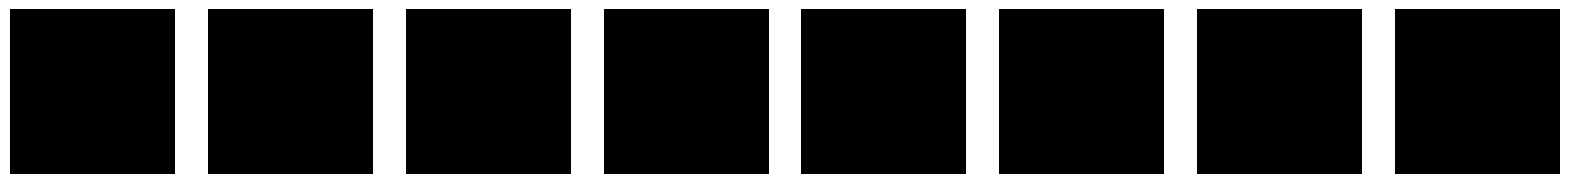

In [83]:
import torch
import matplotlib.pyplot as plt

# Reload models (in case you restarted kernel)
vae_model = VAE(latent_dim=256).to(device)
vae_model.load_state_dict(torch.load("vae_div2k_32.pth"))
vae_model.eval()

unet_model = UNet(latent_dim=256).to(device)
unet_model.load_state_dict(torch.load("unet_diffusion_div2k_32.pth"))
unet_model.eval()

diffusion = Diffusion(timesteps=1000, device=device)

# Sampling function
def sample_ldm(unet, vae, diffusion, num_samples=8, latent_dim=256, timesteps=1000):
    device = next(unet.parameters()).device

    x = torch.randn(num_samples, latent_dim).to(device)
    
    for t in reversed(range(timesteps)):
        t_batch = torch.full((num_samples,), t, device=device, dtype=torch.long)
        with torch.no_grad():
            noise_pred = unet(x, t_batch)
            sqrt_recip_alpha_hat = torch.sqrt(1.0 / diffusion.alpha_hat[t_batch]).unsqueeze(1)
            sqrt_recipm1_alpha_hat = torch.sqrt(1.0 / diffusion.alpha_hat[t_batch] - 1).unsqueeze(1)
            x = sqrt_recip_alpha_hat * (x - sqrt_recipm1_alpha_hat * noise_pred)
            if t > 0:
                noise = torch.randn_like(x)
                beta = diffusion.beta[t_batch].unsqueeze(1)
                x = x + torch.sqrt(beta) * noise

    # Decode latent vectors into images
    with torch.no_grad():
        decoded_imgs = vae.decode(x)
        decoded_imgs = (decoded_imgs + 1) / 2  # Denormalize to [0,1]
    
    return decoded_imgs

# Generate samples
generated_images = sample_ldm(
    unet=unet_model,
    vae=vae_model,
    diffusion=diffusion,
    num_samples=8,
    latent_dim=256,
    timesteps=1000
)

# Plot images
fig, axes = plt.subplots(1, 8, figsize=(20, 5))
for idx, img in enumerate(generated_images):
    img = img.permute(1, 2, 0).cpu().numpy()
    axes[idx].imshow(img)
    axes[idx].axis("off")
plt.show()


In [84]:
import torch
import os
import torchvision.utils as vutils
from tqdm import tqdm

# Reload trained models (if needed)
vae_model = VAE(latent_dim=256).to(device)
vae_model.load_state_dict(torch.load("vae_div2k_32.pth"))
vae_model.eval()

unet_model = UNet(latent_dim=256).to(device)
unet_model.load_state_dict(torch.load("unet_diffusion_div2k_32.pth"))
unet_model.eval()

diffusion = Diffusion(timesteps=1000, device=device)

# Folder to save samples
save_folder = "./generated_div2k_32"
os.makedirs(save_folder, exist_ok=True)

# Sampling function
def sample_ldm(unet, vae, diffusion, num_samples=8, latent_dim=256, timesteps=1000):
    device = next(unet.parameters()).device
    x = torch.randn(num_samples, latent_dim).to(device)
    
    for t in reversed(range(timesteps)):
        t_batch = torch.full((num_samples,), t, device=device, dtype=torch.long)
        with torch.no_grad():
            noise_pred = unet(x, t_batch)
            sqrt_recip_alpha_hat = torch.sqrt(1.0 / diffusion.alpha_hat[t_batch]).unsqueeze(1)
            sqrt_recipm1_alpha_hat = torch.sqrt(1.0 / diffusion.alpha_hat[t_batch] - 1).unsqueeze(1)
            x = sqrt_recip_alpha_hat * (x - sqrt_recipm1_alpha_hat * noise_pred)
            if t > 0:
                noise = torch.randn_like(x)
                beta = diffusion.beta[t_batch].unsqueeze(1)
                x = x + torch.sqrt(beta) * noise

    # Decode latent vectors into images
    with torch.no_grad():
        decoded_imgs = vae.decode(x)
        decoded_imgs = (decoded_imgs + 1) / 2  # Denormalize to [0,1]
    
    return decoded_imgs

# Generate and save 1000 samples
batch_size = 8
num_samples = 1000
num_batches = num_samples // batch_size

print(f" Starting sample generation ({num_samples} images)...")

sample_idx = 0
for _ in tqdm(range(num_batches)):
    samples = sample_ldm(unet_model, vae_model, diffusion, num_samples=batch_size, latent_dim=256, timesteps=1000)
    for img in samples:
        img_path = os.path.join(save_folder, f"sample_{sample_idx:04d}.png")
        vutils.save_image(img, img_path, normalize=True)
        sample_idx += 1

print(f" All {sample_idx} samples saved to {save_folder}")


/tmp/slurmtmp.660196/ipykernel_3271377/46766431.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae_model.load_state_dict(torch.load("vae_div2k_32.pth"))
/tmp/slurmtmp.6

 Starting sample generation (1000 images)...


100%|██████████| 125/125 [00:58<00:00,  2.13it/s]

 All 1000 samples saved to ./generated_div2k_32


In [86]:
import torch
import torchvision.transforms as T
import torchvision.models as models
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
import os
import random
from tqdm import tqdm

# Settings
batch_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generated_folder = './generated_div2k_32/'

# Custom Dataset
class GeneratedDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.folder = folder
        self.image_paths = sorted([
            os.path.join(folder, fname) for fname in os.listdir(folder)
            if fname.endswith('.png')
        ])
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

# Transform
transform = T.Compose([
    T.Resize((299, 299)),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3)
])

# Load InceptionV3
inception_model = models.inception_v3(pretrained=True, transform_input=False).to(device)
inception_model.eval()

# 20 Rounds
inception_scores = []
rounds = 20

print(f" Starting Inception Score evaluation for {rounds} rounds...")

for round_idx in range(rounds):
    # Optional: shuffle images each round
    all_images = os.listdir(generated_folder)
    selected_images = random.sample(all_images, k=1000)

    temp_dataset = GeneratedDataset(
        folder=generated_folder,
        transform=transform
    )
    temp_dataset.image_paths = [os.path.join(generated_folder, fname) for fname in selected_images]
    temp_loader = DataLoader(temp_dataset, batch_size=batch_size, shuffle=False)

    preds = []

    with torch.no_grad():
        for batch in temp_loader:
            batch = batch.to(device)
            logits = inception_model(batch)
            preds.append(F.softmax(logits, dim=1).cpu().numpy())

    preds = np.concatenate(preds, axis=0)
    py = np.mean(preds, axis=0)

    scores = []
    for pred in preds:
        scores.append(np.sum(pred * (np.log(pred + 1e-10) - np.log(py + 1e-10))))

    inception_score = np.exp(np.mean(scores))
    inception_scores.append(inception_score)

    print(f"Round {round_idx+1}/{rounds} IS: {inception_score:.4f}")

# Final Report
mean_is = np.mean(inception_scores)
std_is = np.std(inception_scores)
print(f"\n Final Inception Score over {rounds} rounds: {mean_is:.4f} ± {std_is:.4f}")


 Starting Inception Score evaluation for 20 rounds...
Round 1/20 IS: 1.0000
Round 2/20 IS: 1.0000
Round 3/20 IS: 1.0000
Round 4/20 IS: 1.0000
Round 5/20 IS: 1.0000
Round 6/20 IS: 1.0000
Round 7/20 IS: 1.0000
Round 8/20 IS: 1.0000
Round 9/20 IS: 1.0000
Round 10/20 IS: 1.0000
Round 11/20 IS: 1.0000
Round 12/20 IS: 1.0000
Round 13/20 IS: 1.0000
Round 14/20 IS: 1.0000
Round 15/20 IS: 1.0000
Round 16/20 IS: 1.0000
Round 17/20 IS: 1.0000
Round 18/20 IS: 1.0000
Round 19/20 IS: 1.0000
Round 20/20 IS: 1.0000

 Final Inception Score over 20 rounds: 1.0000 ± 0.0000


In [87]:
import torch
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import numpy as np
from tqdm import tqdm
import random
from skimage.metrics import peak_signal_noise_ratio as compare_psnr

# Settings
batch_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generated_folder = './generated_div2k_32/'   # Your 1000 generated samples
real_folder = './DIV2K_train_HR/'             # Real DIV2K images

# Transform for real images
real_transform = T.Compose([
    T.Resize((32, 32)),
    T.ToTensor()
])

# Dataset for real images
class RealDIV2KDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.folder = folder
        self.image_paths = sorted([
            os.path.join(folder, fname) for fname in os.listdir(folder)
            if fname.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

# Dataset for generated images
class GeneratedDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.folder = folder
        self.image_paths = sorted([
            os.path.join(folder, fname) for fname in os.listdir(folder)
            if fname.endswith('.png')
        ])
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

# Load real dataset
real_dataset = RealDIV2KDataset(real_folder, transform=real_transform)

# 20 rounds
psnr_scores = []
rounds = 20

print(f" Starting PSNR evaluation for {rounds} rounds...")

for round_idx in range(rounds):
    all_generated = os.listdir(generated_folder)
    selected_generated = random.sample(all_generated, k=720)  # 720 to match 90% train

    generated_subset = GeneratedDataset(generated_folder, transform=real_transform)
    generated_subset.image_paths = [os.path.join(generated_folder, fname) for fname in selected_generated]
    generated_loader = DataLoader(generated_subset, batch_size=1, shuffle=False)

    selected_real = random.sample(real_dataset.image_paths, k=720)
    real_subset = RealDIV2KDataset(real_folder, transform=real_transform)
    real_subset.image_paths = selected_real
    real_loader = DataLoader(real_subset, batch_size=1, shuffle=False)

    round_psnr = []

    for (gen_img, real_img) in tqdm(zip(generated_loader, real_loader), total=720, desc=f"Round {round_idx+1}"):
        gen_img = gen_img.squeeze(0)  # remove batch dim
        real_img = real_img.squeeze(0)

        gen_img_np = gen_img.permute(1, 2, 0).cpu().numpy()
        real_img_np = real_img.permute(1, 2, 0).cpu().numpy()

        psnr_value = compare_psnr(real_img_np, gen_img_np, data_range=1.0)
        round_psnr.append(psnr_value)

    mean_psnr = np.mean(round_psnr)
    psnr_scores.append(mean_psnr)
    print(f" Round {round_idx+1}/{rounds} PSNR: {mean_psnr:.2f} dB")

# Final Report
mean_psnr_final = np.mean(psnr_scores)
std_psnr_final = np.std(psnr_scores)
print(f"\n final PSNR over {rounds} rounds: {mean_psnr_final:.2f} ± {std_psnr_final:.2f} dB")


 Starting PSNR evaluation for 20 rounds...


Round 1: 100%|██████████| 720/720 [01:07<00:00, 10.61it/s]


 Round 1/20 PSNR: 6.68 dB


Round 2: 100%|██████████| 720/720 [01:01<00:00, 11.73it/s]


 Round 2/20 PSNR: 6.73 dB


Round 3: 100%|██████████| 720/720 [01:00<00:00, 11.89it/s]


 Round 3/20 PSNR: 6.68 dB


Round 4: 100%|██████████| 720/720 [01:00<00:00, 11.98it/s]


 Round 4/20 PSNR: 6.72 dB


Round 5: 100%|██████████| 720/720 [01:00<00:00, 11.96it/s]


 Round 5/20 PSNR: 6.66 dB


Round 6: 100%|██████████| 720/720 [01:00<00:00, 11.93it/s]


 Round 6/20 PSNR: 6.68 dB


Round 7: 100%|██████████| 720/720 [01:00<00:00, 11.95it/s]


 Round 7/20 PSNR: 6.69 dB


Round 8: 100%|██████████| 720/720 [01:00<00:00, 11.91it/s]


 Round 8/20 PSNR: 6.67 dB


Round 9: 100%|██████████| 720/720 [01:00<00:00, 11.98it/s]


 Round 9/20 PSNR: 6.70 dB


Round 10: 100%|██████████| 720/720 [01:00<00:00, 11.95it/s]


 Round 10/20 PSNR: 6.71 dB


Round 11: 100%|██████████| 720/720 [01:00<00:00, 11.93it/s]


 Round 11/20 PSNR: 6.69 dB


Round 12: 100%|██████████| 720/720 [01:00<00:00, 11.97it/s]


 Round 12/20 PSNR: 6.70 dB


Round 13: 100%|██████████| 720/720 [01:00<00:00, 11.94it/s]


 Round 13/20 PSNR: 6.71 dB


Round 14: 100%|██████████| 720/720 [01:00<00:00, 11.99it/s]


 Round 14/20 PSNR: 6.65 dB


Round 15: 100%|██████████| 720/720 [01:00<00:00, 11.94it/s]


 Round 15/20 PSNR: 6.71 dB


Round 16: 100%|██████████| 720/720 [01:00<00:00, 11.95it/s]


 Round 16/20 PSNR: 6.66 dB


Round 17: 100%|██████████| 720/720 [01:00<00:00, 11.93it/s]


 Round 17/20 PSNR: 6.66 dB


Round 18: 100%|██████████| 720/720 [01:00<00:00, 11.96it/s]


 Round 18/20 PSNR: 6.68 dB


Round 19: 100%|██████████| 720/720 [01:00<00:00, 11.98it/s]


 Round 19/20 PSNR: 6.70 dB


Round 20: 100%|██████████| 720/720 [01:00<00:00, 11.93it/s]

 Round 20/20 PSNR: 6.70 dB

 final PSNR over 20 rounds: 6.69 ± 0.02 dB


In [92]:
import torch
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import numpy as np
from tqdm import tqdm
import random
from skimage.metrics import structural_similarity as compare_ssim

# Settings
batch_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generated_folder = './generated_div2k_32/'   # Your 1000 generated samples
real_folder = './DIV2K_train_HR/'             # Real DIV2K images

# Transform for real images
real_transform = T.Compose([
    T.Resize((32, 32)),
    T.ToTensor()
])

# Dataset for real images
class RealDIV2KDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.folder = folder
        self.image_paths = sorted([
            os.path.join(folder, fname) for fname in os.listdir(folder)
            if fname.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

# Dataset for generated images
class GeneratedDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.folder = folder
        self.image_paths = sorted([
            os.path.join(folder, fname) for fname in os.listdir(folder)
            if fname.endswith('.png')
        ])
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

# Load real dataset
real_dataset = RealDIV2KDataset(real_folder, transform=real_transform)

# 20 rounds
ssim_scores = []
rounds = 20

print(f" Starting SSIM evaluation for {rounds} rounds...")

for round_idx in range(rounds):
    all_generated = os.listdir(generated_folder)
    selected_generated = random.sample(all_generated, k=720)  # 720 to match 90% train

    generated_subset = GeneratedDataset(generated_folder, transform=real_transform)
    generated_subset.image_paths = [os.path.join(generated_folder, fname) for fname in selected_generated]
    generated_loader = DataLoader(generated_subset, batch_size=1, shuffle=False)

    selected_real = random.sample(real_dataset.image_paths, k=720)
    real_subset = RealDIV2KDataset(real_folder, transform=real_transform)
    real_subset.image_paths = selected_real
    real_loader = DataLoader(real_subset, batch_size=1, shuffle=False)

    round_ssim = []

    for (gen_img, real_img) in tqdm(zip(generated_loader, real_loader), total=720, desc=f"Round {round_idx+1}"):
        gen_img = gen_img.squeeze(0)  # remove batch dim
        real_img = real_img.squeeze(0)

        gen_img_np = gen_img.permute(1, 2, 0).cpu().numpy()
        real_img_np = real_img.permute(1, 2, 0).cpu().numpy()

        ssim_value = compare_ssim(real_img_np, gen_img_np, win_size=5, channel_axis=-1, data_range=1.0)
        round_ssim.append(ssim_value)

    mean_ssim = np.mean(round_ssim)
    ssim_scores.append(mean_ssim)
    print(f" Round {round_idx+1}/{rounds} SSIM: {mean_ssim:.4f}")

# Final Report
mean_ssim_final = np.mean(ssim_scores)
std_ssim_final = np.std(ssim_scores)
print(f"\n final SSIM over {rounds} rounds: {mean_ssim_final:.4f} ± {std_ssim_final:.4f}")


 Starting SSIM evaluation for 20 rounds...


Round 1: 100%|██████████| 720/720 [01:01<00:00, 11.77it/s]


 Round 1/20 SSIM: 0.0046


Round 2: 100%|██████████| 720/720 [01:00<00:00, 11.83it/s]


 Round 2/20 SSIM: 0.0042


Round 3: 100%|██████████| 720/720 [01:00<00:00, 11.83it/s]


 Round 3/20 SSIM: 0.0043


Round 4: 100%|██████████| 720/720 [01:00<00:00, 11.85it/s]


 Round 4/20 SSIM: 0.0046


Round 5: 100%|██████████| 720/720 [01:01<00:00, 11.79it/s]


 Round 5/20 SSIM: 0.0042


Round 6: 100%|██████████| 720/720 [01:00<00:00, 11.83it/s]


 Round 6/20 SSIM: 0.0044


Round 7: 100%|██████████| 720/720 [01:00<00:00, 11.82it/s]


 Round 7/20 SSIM: 0.0043


Round 8: 100%|██████████| 720/720 [01:00<00:00, 11.88it/s]


 Round 8/20 SSIM: 0.0044


Round 9: 100%|██████████| 720/720 [01:00<00:00, 11.87it/s]


 Round 9/20 SSIM: 0.0046


Round 10: 100%|██████████| 720/720 [01:00<00:00, 11.82it/s]


 Round 10/20 SSIM: 0.0045


Round 11: 100%|██████████| 720/720 [01:00<00:00, 11.84it/s]


 Round 11/20 SSIM: 0.0047


Round 12: 100%|██████████| 720/720 [01:00<00:00, 11.86it/s]


 Round 12/20 SSIM: 0.0044


Round 13: 100%|██████████| 720/720 [01:00<00:00, 11.86it/s]


 Round 13/20 SSIM: 0.0044


Round 14: 100%|██████████| 720/720 [01:01<00:00, 11.69it/s]


 Round 14/20 SSIM: 0.0042


Round 15: 100%|██████████| 720/720 [01:00<00:00, 11.84it/s]


 Round 15/20 SSIM: 0.0044


Round 16: 100%|██████████| 720/720 [01:00<00:00, 11.84it/s]


 Round 16/20 SSIM: 0.0040


Round 17: 100%|██████████| 720/720 [01:00<00:00, 11.87it/s]


 Round 17/20 SSIM: 0.0040


Round 18: 100%|██████████| 720/720 [01:00<00:00, 11.85it/s]


 Round 18/20 SSIM: 0.0046


Round 19: 100%|██████████| 720/720 [01:00<00:00, 11.88it/s]


 Round 19/20 SSIM: 0.0044


Round 20: 100%|██████████| 720/720 [01:00<00:00, 11.84it/s]

 Round 20/20 SSIM: 0.0046

 final SSIM over 20 rounds: 0.0044 ± 0.0002


In [94]:
import torch
import torchvision.transforms as T
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import numpy as np
from tqdm import tqdm
import random
import torch.nn.functional as F

# Settings
batch_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generated_folder = './generated_div2k_32/'   
real_folder = './DIV2K_train_HR/'             

# Transform for real images
real_transform = T.Compose([
    T.Resize((224, 224)),  # VGG16 expects 224x224
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225])
])

# Dataset for real images
class RealDIV2KDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.folder = folder
        self.image_paths = sorted([
            os.path.join(folder, fname) for fname in os.listdir(folder)
            if fname.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

# Dataset for generated images
class GeneratedDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.folder = folder
        self.image_paths = sorted([
            os.path.join(folder, fname) for fname in os.listdir(folder)
            if fname.endswith('.png')
        ])
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

# Load real dataset
real_dataset = RealDIV2KDataset(real_folder, transform=real_transform)

# Load pretrained VGG16 for perceptual feature extraction
vgg16 = models.vgg16(pretrained=True).features[:16].to(device).eval()

# 20 rounds
perceptual_similarity_scores = []
rounds = 20

print(f"Starting Perceptual Similarity (VGG features) evaluation for {rounds} rounds...")

for round_idx in range(rounds):
    all_generated = os.listdir(generated_folder)
    selected_generated = random.sample(all_generated, k=720)

    generated_subset = GeneratedDataset(generated_folder, transform=real_transform)
    generated_subset.image_paths = [os.path.join(generated_folder, fname) for fname in selected_generated]
    generated_loader = DataLoader(generated_subset, batch_size=1, shuffle=False)

    selected_real = random.sample(real_dataset.image_paths, k=720)
    real_subset = RealDIV2KDataset(real_folder, transform=real_transform)
    real_subset.image_paths = selected_real
    real_loader = DataLoader(real_subset, batch_size=1, shuffle=False)

    round_perceptual_similarities = []

    for (gen_img, real_img) in tqdm(zip(generated_loader, real_loader), total=720, desc=f"Round {round_idx+1}"):
        gen_img = gen_img.squeeze(0).unsqueeze(0).to(device)
        real_img = real_img.squeeze(0).unsqueeze(0).to(device)

        with torch.no_grad():
            feat_gen = vgg16(gen_img)
            feat_real = vgg16(real_img)

        # Calculate L2 distance between features
        perceptual_distance = F.mse_loss(feat_gen, feat_real, reduction='mean').item()

        # Convert to similarity: similarity = 1 / (1 + distance)
        perceptual_similarity = 1 / (1 + perceptual_distance)

        round_perceptual_similarities.append(perceptual_similarity)

    mean_perceptual_similarity = np.mean(round_perceptual_similarities)
    perceptual_similarity_scores.append(mean_perceptual_similarity)
    print(f" Round {round_idx+1}/{rounds} Perceptual Similarity: {mean_perceptual_similarity:.6f}")

# Final Report
mean_perceptual_similarity_final = np.mean(perceptual_similarity_scores)
std_perceptual_similarity_final = np.std(perceptual_similarity_scores)
print(f"\nFinal Perceptual Similarity over {rounds} rounds: {mean_perceptual_similarity_final:.6f} ± {std_perceptual_similarity_final:.6f}")


Starting Perceptual Similarity (VGG features) evaluation for 20 rounds...


Round 1: 100%|██████████| 720/720 [01:04<00:00, 11.12it/s]


 Round 1/20 Perceptual Similarity: 0.066464


Round 2: 100%|██████████| 720/720 [01:05<00:00, 11.08it/s]


 Round 2/20 Perceptual Similarity: 0.066026


Round 3: 100%|██████████| 720/720 [01:04<00:00, 11.13it/s]


 Round 3/20 Perceptual Similarity: 0.066048


Round 4: 100%|██████████| 720/720 [01:04<00:00, 11.11it/s]


 Round 4/20 Perceptual Similarity: 0.066529


Round 5: 100%|██████████| 720/720 [01:04<00:00, 11.11it/s]


 Round 5/20 Perceptual Similarity: 0.066572


Round 6: 100%|██████████| 720/720 [01:04<00:00, 11.09it/s]


 Round 6/20 Perceptual Similarity: 0.065967


Round 7: 100%|██████████| 720/720 [01:04<00:00, 11.10it/s]


 Round 7/20 Perceptual Similarity: 0.066166


Round 8: 100%|██████████| 720/720 [01:04<00:00, 11.09it/s]


 Round 8/20 Perceptual Similarity: 0.066192


Round 9: 100%|██████████| 720/720 [01:04<00:00, 11.09it/s]


 Round 9/20 Perceptual Similarity: 0.066159


Round 10: 100%|██████████| 720/720 [01:04<00:00, 11.11it/s]


 Round 10/20 Perceptual Similarity: 0.066582


Round 11: 100%|██████████| 720/720 [01:04<00:00, 11.11it/s]


 Round 11/20 Perceptual Similarity: 0.066148


Round 12: 100%|██████████| 720/720 [01:04<00:00, 11.11it/s]


 Round 12/20 Perceptual Similarity: 0.066200


Round 13: 100%|██████████| 720/720 [01:04<00:00, 11.10it/s]


 Round 13/20 Perceptual Similarity: 0.066004


Round 14: 100%|██████████| 720/720 [01:05<00:00, 11.04it/s]


 Round 14/20 Perceptual Similarity: 0.065730


Round 15: 100%|██████████| 720/720 [01:04<00:00, 11.09it/s]


 Round 15/20 Perceptual Similarity: 0.066325


Round 16: 100%|██████████| 720/720 [01:04<00:00, 11.08it/s]


 Round 16/20 Perceptual Similarity: 0.066187


Round 17: 100%|██████████| 720/720 [01:05<00:00, 11.05it/s]


 Round 17/20 Perceptual Similarity: 0.066063


Round 18: 100%|██████████| 720/720 [01:04<00:00, 11.10it/s]


 Round 18/20 Perceptual Similarity: 0.065950


Round 19: 100%|██████████| 720/720 [01:04<00:00, 11.10it/s]


 Round 19/20 Perceptual Similarity: 0.065845


Round 20: 100%|██████████| 720/720 [01:04<00:00, 11.11it/s]

 Round 20/20 Perceptual Similarity: 0.065980

Final Perceptual Similarity over 20 rounds: 0.066157 ± 0.000231


In [97]:
import torch
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import numpy as np
from tqdm import tqdm
import random
from torchvision.models import inception_v3
import torch.nn.functional as F
from scipy import linalg

# Settings
batch_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generated_folder = './generated_div2k_32/'
real_folder = './DIV2K_train_HR/'

# Transform for InceptionV3
transform_inception = T.Compose([
    T.Resize((299, 299)),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5],
                std=[0.5, 0.5, 0.5])
])

# Dataset class with directory check
class CustomImageDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.folder = folder
        self.image_paths = []
        for fname in sorted(os.listdir(folder)):
            full_path = os.path.join(folder, fname)
            if os.path.isfile(full_path) and fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                self.image_paths.append(full_path)
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

# InceptionV3 model for feature extraction
inception_model = inception_v3(pretrained=True, transform_input=False).to(device)
inception_model.fc = torch.nn.Identity()  # remove final classification layer
inception_model.eval()

# Extract features from InceptionV3
def get_inception_features(dataloader):
    features = []
    with torch.no_grad():
        for imgs in dataloader:
            imgs = imgs.to(device)
            preds = inception_model(imgs)
            features.append(preds.cpu().numpy())
    features = np.concatenate(features, axis=0)
    return features

# FID calculation
def calculate_fid(mu1, sigma1, mu2, sigma2):
    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

# 20 rounds
fid_scores = []
rounds = 20

print(f"Starting FID evaluation for {rounds} rounds...")

for round_idx in range(rounds):
    # Select 720 random images
    selected_gen = random.sample(
        [f for f in os.listdir(generated_folder) if os.path.isfile(os.path.join(generated_folder, f))], k=720)
    selected_real = random.sample(
        [f for f in os.listdir(real_folder) if os.path.isfile(os.path.join(real_folder, f))], k=720)

    # Datasets
    gen_dataset = CustomImageDataset(generated_folder, transform=transform_inception)
    gen_dataset.image_paths = [os.path.join(generated_folder, f) for f in selected_gen]
    real_dataset = CustomImageDataset(real_folder, transform=transform_inception)
    real_dataset.image_paths = [os.path.join(real_folder, f) for f in selected_real]

    # Loaders
    gen_loader = DataLoader(gen_dataset, batch_size=batch_size, shuffle=False)
    real_loader = DataLoader(real_dataset, batch_size=batch_size, shuffle=False)

    print(f"Extracting features for Round {round_idx+1}...")
    feat_gen = get_inception_features(gen_loader)
    feat_real = get_inception_features(real_loader)

    mu_gen, sigma_gen = np.mean(feat_gen, axis=0), np.cov(feat_gen, rowvar=False)
    mu_real, sigma_real = np.mean(feat_real, axis=0), np.cov(feat_real, rowvar=False)

    fid = calculate_fid(mu_gen, sigma_gen, mu_real, sigma_real)
    fid_scores.append(fid)

    print(f" Round {round_idx+1}/{rounds} FID: {fid:.2f}")

# Final Report
mean_fid = np.mean(fid_scores)
std_fid = np.std(fid_scores)
print(f"\nFinal FID over {rounds} rounds: {mean_fid:.2f} ± {std_fid:.2f}")


Starting FID evaluation for 20 rounds...
Extracting features for Round 1...
 Round 1/20 FID: 429.05
Extracting features for Round 2...
 Round 2/20 FID: 425.84
Extracting features for Round 3...
 Round 3/20 FID: 425.55
Extracting features for Round 4...
 Round 4/20 FID: 426.97
Extracting features for Round 5...
 Round 5/20 FID: 427.34
Extracting features for Round 6...
 Round 6/20 FID: 424.26
Extracting features for Round 7...
 Round 7/20 FID: 426.08
Extracting features for Round 8...
 Round 8/20 FID: 427.23
Extracting features for Round 9...
 Round 9/20 FID: 426.95
Extracting features for Round 10...
 Round 10/20 FID: 427.29
Extracting features for Round 11...
 Round 11/20 FID: 425.93
Extracting features for Round 12...
 Round 12/20 FID: 425.13
Extracting features for Round 13...
 Round 13/20 FID: 427.46
Extracting features for Round 14...
 Round 14/20 FID: 425.88
Extracting features for Round 15...
 Round 15/20 FID: 424.18
Extracting features for Round 16...
 Round 16/20 FID: 424.08
E

In [1]:
import torch
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import numpy as np
from tqdm import tqdm
import random
from torchvision.models import inception_v3
import torch.nn.functional as F
from scipy import linalg

# Settings
batch_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generated_folder = './generated_div2k_32/'   
real_folder = './DIV2K_train_HR/'             

# Transform for InceptionV3
transform_inception = T.Compose([
    T.Resize((299, 299)),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5],
                std=[0.5, 0.5, 0.5])
])

# Dataset class with file filtering
class CustomImageDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.folder = folder
        self.image_paths = []
        for fname in sorted(os.listdir(folder)):
            full_path = os.path.join(folder, fname)
            if os.path.isfile(full_path) and fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                self.image_paths.append(full_path)
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

# InceptionV3 model for feature extraction
inception_model = inception_v3(pretrained=True, transform_input=False).to(device)
inception_model.fc = torch.nn.Identity()
inception_model.eval()

# Extract features
def get_inception_features(dataloader):
    features = []
    with torch.no_grad():
        for imgs in dataloader:
            imgs = imgs.to(device)
            preds = inception_model(imgs)
            features.append(preds.cpu().numpy())
    features = np.concatenate(features, axis=0)
    return features

# Calculate polynomial kernel (for KID)
def polynomial_kernel(X, Y):
    return (X @ Y.T / X.shape[1] + 1)**3

# Calculate KID
def calculate_kid(feat_real, feat_fake):
    X = feat_real
    Y = feat_fake
    K_XX = polynomial_kernel(X, X)
    K_YY = polynomial_kernel(Y, Y)
    K_XY = polynomial_kernel(X, Y)
    m = X.shape[0]
    n = Y.shape[0]
    sum_K_XX = (np.sum(K_XX) - np.trace(K_XX)) / (m * (m - 1))
    sum_K_YY = (np.sum(K_YY) - np.trace(K_YY)) / (n * (n - 1))
    sum_K_XY = np.sum(K_XY) / (m * n)
    return sum_K_XX + sum_K_YY - 2 * sum_K_XY

# 20 rounds
kid_scores = []
rounds = 20

print(f"Starting KID evaluation for {rounds} rounds...")

for round_idx in range(rounds):
    selected_gen = random.sample(
        [f for f in os.listdir(generated_folder) if os.path.isfile(os.path.join(generated_folder, f))], k=720)
    selected_real = random.sample(
        [f for f in os.listdir(real_folder) if os.path.isfile(os.path.join(real_folder, f))], k=720)

    gen_dataset = CustomImageDataset(generated_folder, transform=transform_inception)
    gen_dataset.image_paths = [os.path.join(generated_folder, f) for f in selected_gen]
    real_dataset = CustomImageDataset(real_folder, transform=transform_inception)
    real_dataset.image_paths = [os.path.join(real_folder, f) for f in selected_real]

    gen_loader = DataLoader(gen_dataset, batch_size=batch_size, shuffle=False)
    real_loader = DataLoader(real_dataset, batch_size=batch_size, shuffle=False)

    print(f"Extracting features for Round {round_idx+1}...")
    feat_gen = get_inception_features(gen_loader)
    feat_real = get_inception_features(real_loader)

    kid = calculate_kid(feat_real, feat_gen)
    kid_scores.append(kid)

    print(f" Round {round_idx+1}/{rounds} KID: {kid:.6f}")

# Final Report
mean_kid = np.mean(kid_scores)
std_kid = np.std(kid_scores)
print(f"\nFinal KID over {rounds} rounds: {mean_kid:.6f} ± {std_kid:.6f}")


/users/PFS0270/nikhilchatta/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/users/PFS0270/nikhilchatta/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting KID evaluation for 20 rounds...
Extracting features for Round 1...
 Round 1/20 KID: 0.370075
Extracting features for Round 2...
 Round 2/20 KID: 0.370863
Extracting features for Round 3...
 Round 3/20 KID: 0.371011
Extracting features for Round 4...
 Round 4/20 KID: 0.370363
Extracting features for Round 5...
 Round 5/20 KID: 0.371231
Extracting features for Round 6...
 Round 6/20 KID: 0.370895
Extracting features for Round 7...
 Round 7/20 KID: 0.372200
Extracting features for Round 8...
 Round 8/20 KID: 0.373339
Extracting features for Round 9...
 Round 9/20 KID: 0.371697
Extracting features for Round 10...
 Round 10/20 KID: 0.371470
Extracting features for Round 11...
 Round 11/20 KID: 0.371909
Extracting features for Round 12...
 Round 12/20 KID: 0.371863
Extracting features for Round 13...
 Round 13/20 KID: 0.374367
Extracting features for Round 14...
 Round 14/20 KID: 0.371233
Extracting features for Round 15...
 Round 15/20 KID: 0.372917
Extracting features for Round 16

In [2]:
import torch
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import numpy as np
from tqdm import tqdm
import random
import lpips

# Settings
batch_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generated_folder = './generated_div2k_32/'
real_folder = './DIV2K_train_HR/'

# Transform for LPIPS model
transform_lpips = T.Compose([
    T.Resize((256, 256)),  # LPIPS can work with 256x256 size easily
    T.ToTensor(),
])

# Dataset class with directory check
class CustomImageDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.folder = folder
        self.image_paths = []
        for fname in sorted(os.listdir(folder)):
            full_path = os.path.join(folder, fname)
            if os.path.isfile(full_path) and fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                self.image_paths.append(full_path)
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

# LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)  # You can change 'alex' to 'vgg' or 'squeeze' if needed
lpips_model.eval()

# 20 rounds
lpips_scores = []
rounds = 20

print(f"Starting LPIPS evaluation for {rounds} rounds...")

for round_idx in range(rounds):
    selected_gen = random.sample(
        [f for f in os.listdir(generated_folder) if os.path.isfile(os.path.join(generated_folder, f))], k=720)
    selected_real = random.sample(
        [f for f in os.listdir(real_folder) if os.path.isfile(os.path.join(real_folder, f))], k=720)

    gen_dataset = CustomImageDataset(generated_folder, transform=transform_lpips)
    gen_dataset.image_paths = [os.path.join(generated_folder, f) for f in selected_gen]
    real_dataset = CustomImageDataset(real_folder, transform=transform_lpips)
    real_dataset.image_paths = [os.path.join(real_folder, f) for f in selected_real]

    gen_loader = DataLoader(gen_dataset, batch_size=1, shuffle=False)
    real_loader = DataLoader(real_dataset, batch_size=1, shuffle=False)

    round_lpips = []

    for (gen_img, real_img) in tqdm(zip(gen_loader, real_loader), total=720, desc=f"Round {round_idx+1}"):
        gen_img = gen_img.squeeze(0).unsqueeze(0).to(device)  # Shape (1, 3, 256, 256)
        real_img = real_img.squeeze(0).unsqueeze(0).to(device)

        with torch.no_grad():
            lpips_value = lpips_model(gen_img, real_img).item()

        round_lpips.append(lpips_value)

    mean_lpips = np.mean(round_lpips)
    lpips_scores.append(mean_lpips)

    print(f" Round {round_idx+1}/{rounds} LPIPS: {mean_lpips:.6f}")

# Final Report
mean_lpips_final = np.mean(lpips_scores)
std_lpips_final = np.std(lpips_scores)
print(f"\nFinal LPIPS over {rounds} rounds: {mean_lpips_final:.6f} ± {std_lpips_final:.6f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/users/PFS0270/nikhilchatta/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/users/PFS0270/nikhilchatta/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/users/PFS0270/nikhilchatta/.local/lib/python3.9/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (S

Loading model from: /users/PFS0270/nikhilchatta/.local/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth
Starting LPIPS evaluation for 20 rounds...


Round 1: 100%|██████████| 720/720 [01:18<00:00,  9.12it/s]


 Round 1/20 LPIPS: 0.818397


Round 2: 100%|██████████| 720/720 [01:11<00:00, 10.13it/s]


 Round 2/20 LPIPS: 0.817274


Round 3: 100%|██████████| 720/720 [01:09<00:00, 10.37it/s]


 Round 3/20 LPIPS: 0.816603


Round 4: 100%|██████████| 720/720 [01:08<00:00, 10.51it/s]


 Round 4/20 LPIPS: 0.818155


Round 5: 100%|██████████| 720/720 [01:08<00:00, 10.49it/s]


 Round 5/20 LPIPS: 0.816586


Round 6: 100%|██████████| 720/720 [01:13<00:00,  9.75it/s]


 Round 6/20 LPIPS: 0.817939


Round 7: 100%|██████████| 720/720 [01:11<00:00, 10.07it/s]


 Round 7/20 LPIPS: 0.818558


Round 8: 100%|██████████| 720/720 [01:09<00:00, 10.40it/s]


 Round 8/20 LPIPS: 0.818252


Round 9: 100%|██████████| 720/720 [01:08<00:00, 10.48it/s]


 Round 9/20 LPIPS: 0.816322


Round 10: 100%|██████████| 720/720 [01:08<00:00, 10.59it/s]


 Round 10/20 LPIPS: 0.818220


Round 11: 100%|██████████| 720/720 [01:08<00:00, 10.58it/s]


 Round 11/20 LPIPS: 0.817342


Round 12: 100%|██████████| 720/720 [01:09<00:00, 10.43it/s]


 Round 12/20 LPIPS: 0.817518


Round 13: 100%|██████████| 720/720 [01:12<00:00,  9.87it/s]


 Round 13/20 LPIPS: 0.817283


Round 14: 100%|██████████| 720/720 [01:10<00:00, 10.28it/s]


 Round 14/20 LPIPS: 0.817148


Round 15: 100%|██████████| 720/720 [01:08<00:00, 10.51it/s]


 Round 15/20 LPIPS: 0.817855


Round 16: 100%|██████████| 720/720 [01:08<00:00, 10.47it/s]


 Round 16/20 LPIPS: 0.815939


Round 17: 100%|██████████| 720/720 [01:09<00:00, 10.33it/s]


 Round 17/20 LPIPS: 0.818788


Round 18: 100%|██████████| 720/720 [01:08<00:00, 10.53it/s]


 Round 18/20 LPIPS: 0.817309


Round 19: 100%|██████████| 720/720 [01:08<00:00, 10.55it/s]


 Round 19/20 LPIPS: 0.817253


Round 20: 100%|██████████| 720/720 [01:08<00:00, 10.54it/s]

 Round 20/20 LPIPS: 0.817783

Final LPIPS over 20 rounds: 0.817526 ± 0.000751


In [ ]:
!git init
!git add .
!git commit -m "LDM"


Reinitialized existing Git repository in /users/PFS0270/nikhilchatta/.git/


In [ ]:
git remote add origin git@github.com:nikhilchatta/LatentDiffusion.git
git branch -M main
git push -u origin main
